# Example of snowcam image processing to help Ellie
## modified from original geltrap image processing

### First import functions needed and path of the image file

In [258]:
%matplotlib notebook

import sys, os
import numpy as np
from skimage import io, filters, color, measure, util, morphology, exposure
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.filters import sobel
import math
import pandas as pd
import time
import shutil

input_path = '/Users/colleen/Projects/EXPORTS/snowcam/test_for_ellie/photos'
file = 'Sep__5_08-26-12_2018.jpg'

##You will need to measure the pixels per micron for this camera
##This number is not correct
scale = 0.1268


## read image file, convert to greyscale and also pull and red and blue channels

In [259]:

photo = io.imread(os.path.join(input_path,file), plugin='pil')
photo_grey1 = color.rgb2grey(photo) #converts to luminescence units, scale -1 to 1 (Y = 0.2125 R + 0.7154 G + 0.0721 B)
photo_grey=util.img_as_ubyte(photo_grey1) #converts to a 8-bit ubyte, scale 0 to 255
photo_red1 = photo[:,:,0]
photo_red=util.img_as_ubyte(photo_red1)
photo_blue1 = photo[:,:,2]
photo_blue=util.img_as_ubyte(photo_blue1)

/Users/colleen/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


## Rescale all the single-channel images between zero and their maximum pixel intensities.  This is meant to account for changes in the background brightness between different images.  I don't know if this will work, but I think something like it will.

<IPython.core.display.Javascript object>


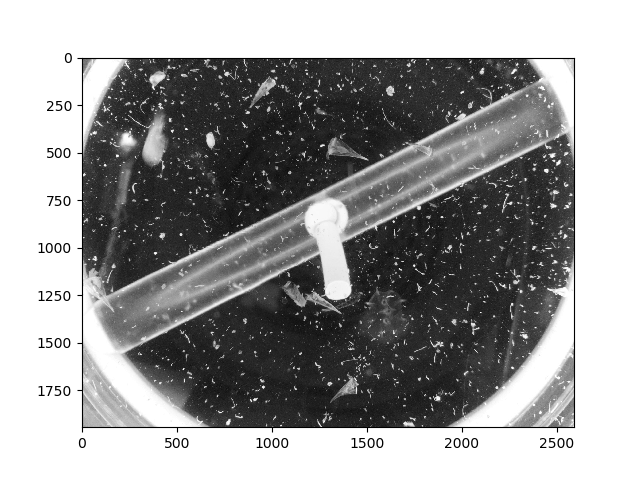

In [260]:
from skimage.exposure import rescale_intensity
photo_grey_rescaled = rescale_intensity(photo_grey, out_range=(0,np.max(photo_grey)))
photo_red_rescaled = rescale_intensity(photo_red, out_range=(0,np.max(photo_red)))
photo_blue_rescaled = rescale_intensity(photo_blue, out_range=(0,np.max(photo_blue)))
plt.figure()
plt.imshow(photo_grey_rescaled,cmap=plt.cm.gray)


### Create a median filter of each single-channel images.  I change the disk size over which the median is calculated to 100 pixels. This is smaller than what was used for the gel traps.  You don't want the disk size to be smaller than your largest particles, but if the size it too big it will not detect background variation/noise.  For this camera, 100 seems to be around the right size.

<IPython.core.display.Javascript object>


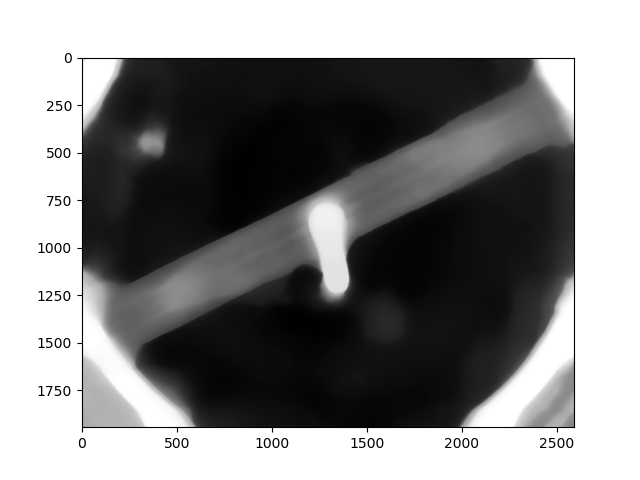

<IPython.core.display.Javascript object>


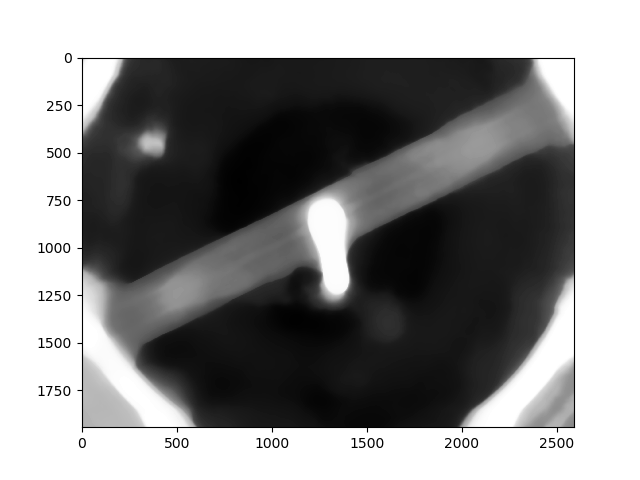

<IPython.core.display.Javascript object>


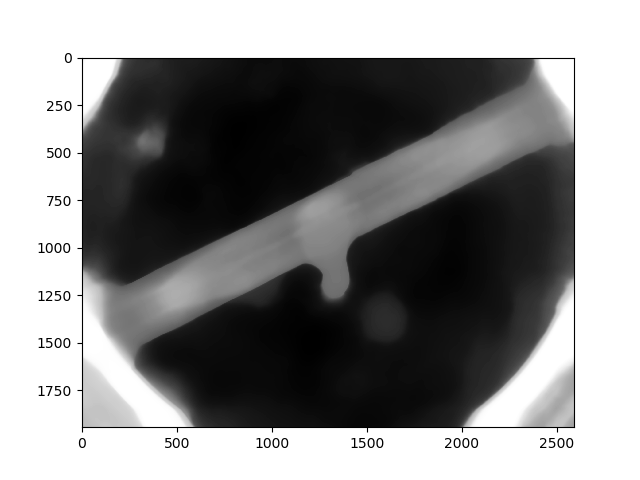

In [219]:
photo_grey_median = filters.median(photo_grey_rescaled,selem=morphology.disk(100)) #disk shape over which median value is calculated must be larger than the largest particle
photo_red_median = filters.median(photo_red_rescaled,selem=morphology.disk(100)) 
photo_blue_median = filters.median(photo_blue_rescaled,selem=morphology.disk(100))
plt.figure()
plt.imshow(photo_grey_median,cmap=plt.cm.gray)
plt.figure()
plt.imshow(photo_red_median,cmap=plt.cm.gray)
plt.figure()
plt.imshow(photo_blue_median,cmap=plt.cm.gray)

### Subtract the background from each single-channel image by 1) subtracting the median pixel intensity from the median filtered image and 2) subtracting that differenence-image from your single-channel image.
### Highlight dark brown particles by subtracting the blue from the red background-subtracted images.
### Then, rescale your grey and brown background-subtracted images.

<IPython.core.display.Javascript object>


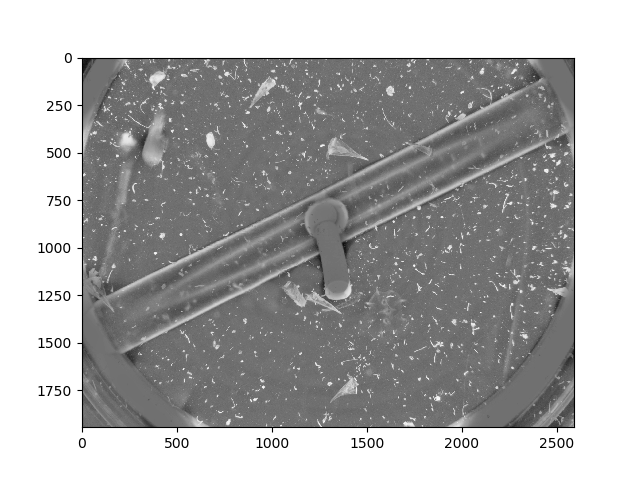

<IPython.core.display.Javascript object>


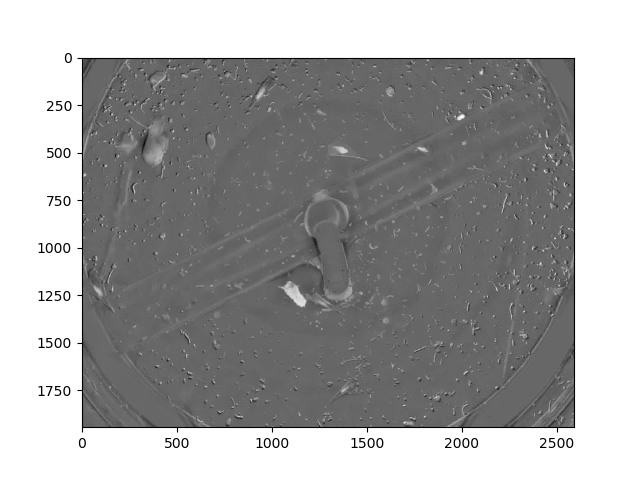

In [220]:
median_grey_value=np.median(photo_grey_rescaled)
median_red_value=np.median(photo_red_rescaled)
median_blue_value=np.median(photo_blue_rescaled)
photo_grey_median_diff = photo_grey_median - median_grey_value #difference between median filtered image and the median value of the image.  Use this to indicate variation in the background intensity across the image space.
photo_red_median_diff = photo_red_median - median_red_value 
photo_blue_median_diff = photo_blue_median - median_blue_value 

photo_grey_nobg = photo_grey_rescaled-photo_grey_median_diff #background subtracted from the grey-scale image.  This step is especially necessary if the lighting is not even across the entire image (e.g. top of image is brighter than the bottom of the image)
photo_red_nobg = photo_red_rescaled-photo_red_median_diff
photo_blue_nobg = photo_blue_rescaled-photo_blue_median_diff

photo_brown_nobg= photo_red_nobg - photo_blue_nobg

photo_grey_nobg_rescaled = rescale_intensity(photo_grey_nobg, out_range=(0,np.max(photo_grey_nobg)))
photo_brown_nobg_rescaled = rescale_intensity(photo_brown_nobg, out_range=(0,np.max(photo_brown_nobg)))

plt.figure()
plt.imshow(photo_grey_nobg_rescaled,cmap=plt.cm.gray)
plt.figure()
plt.imshow(photo_brown_nobg_rescaled,cmap=plt.cm.gray)


### Visualize the distribution of pixel intensities in the greyscale and brown background subracted images

<IPython.core.display.Javascript object>


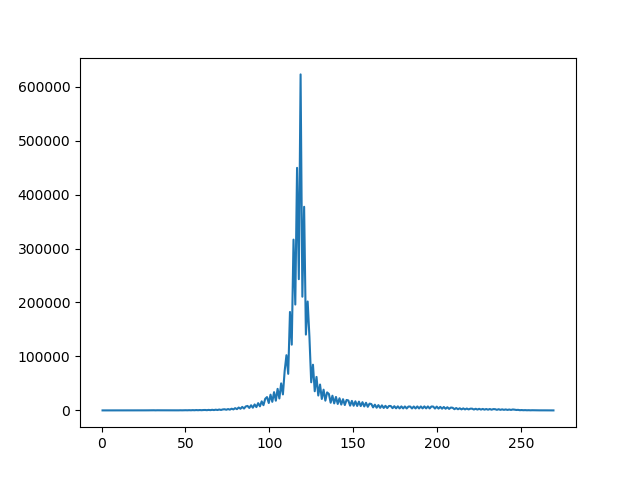

<IPython.core.display.Javascript object>


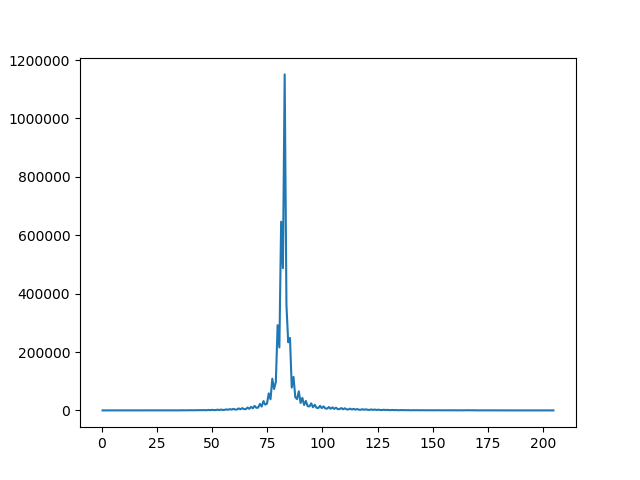

In [221]:
grey_hist=exposure.histogram(photo_grey_nobg_rescaled)
brown_hist=exposure.histogram(photo_brown_nobg_rescaled)
plt.figure()
plt.plot(grey_hist[1],grey_hist[0])
plt.figure()
plt.plot(brown_hist[1],brown_hist[0])

### Calculate the mode pixel intensity and then define threshold values as 25% larger than that value.  I chose 25% by trial and error.  This is something you will want to make sure works well for all your images.

<IPython.core.display.Javascript object>


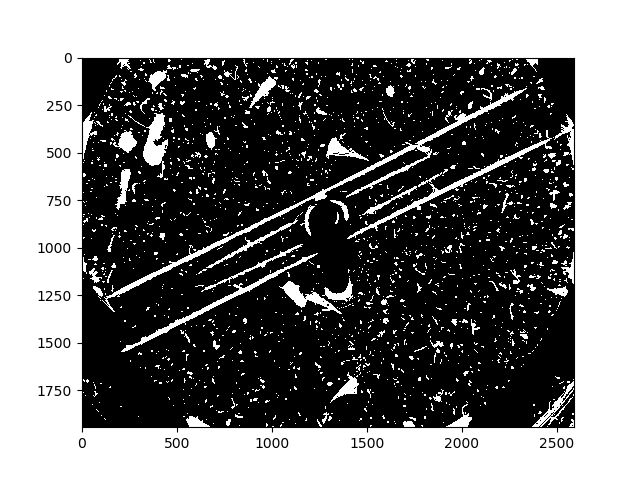

In [224]:
mode_intensity_grey = grey_hist[1][np.where(grey_hist[0]==np.max(grey_hist[0]))]
mode_intensity_brown = brown_hist[1][np.where(brown_hist[0]==np.max(brown_hist[0]))]

markers = np.zeros_like(photo_grey_nobg_rescaled)
markers[photo_grey_nobg_rescaled >= (mode_intensity_grey*1.25)] = 1
markers[photo_brown_nobg_rescaled > (mode_intensity_brown*1.25)] = 1

plt.figure()
plt.imshow(markers,cmap=plt.cm.gray)

### Fill holes in the particles and label them (for later use)

<IPython.core.display.Javascript object>


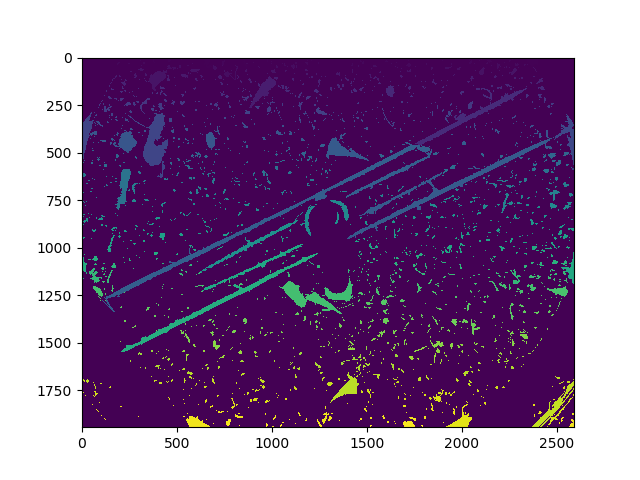

In [225]:
markers_fill = ndi.morphology.binary_fill_holes(markers)
labeled_particles, _ = ndi.label(markers_fill)
plt.figure()
plt.imshow(labeled_particles)

### Apply a sobel filter to the particles to identify sharp edges.  Mask the middle of the particle with an eroded particle mask.

<IPython.core.display.Javascript object>


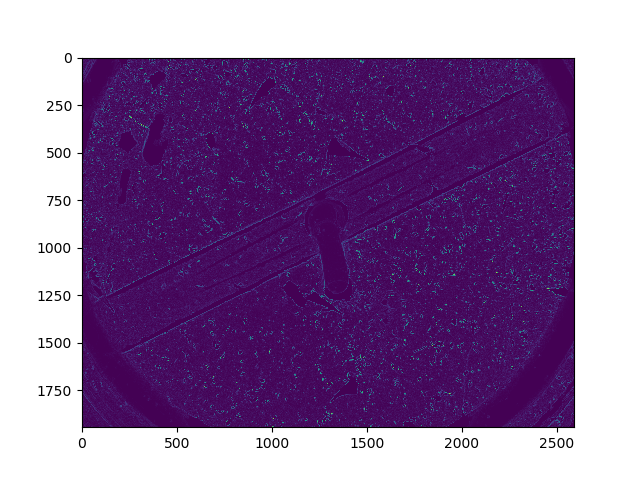

In [226]:
particle_erode = morphology.erosion(markers_fill, selem = morphology.disk(1))
elevation_map = sobel(photo_grey_nobg_rescaled)
elevation_map[particle_erode==True]=0
plt.figure()
plt.imshow(elevation_map)


### Look at the distribution of edge intensities calculated by the sobel filter

<IPython.core.display.Javascript object>


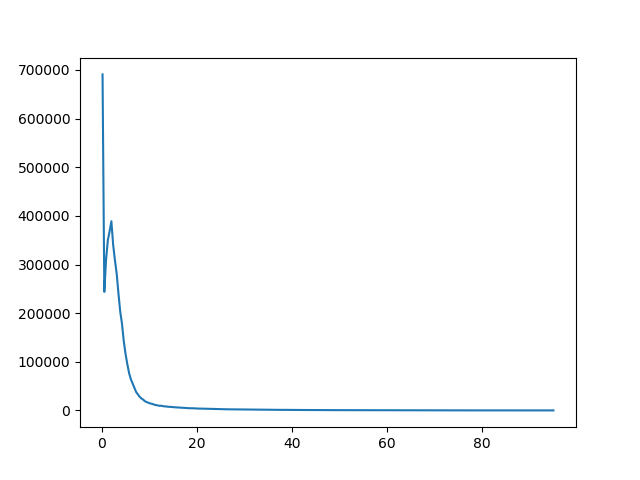

In [228]:
hist = exposure.histogram(elevation_map)
plt.figure()
plt.plot(hist[1],hist[0])

### Choose the threshold that defines an in-focus edge

<IPython.core.display.Javascript object>


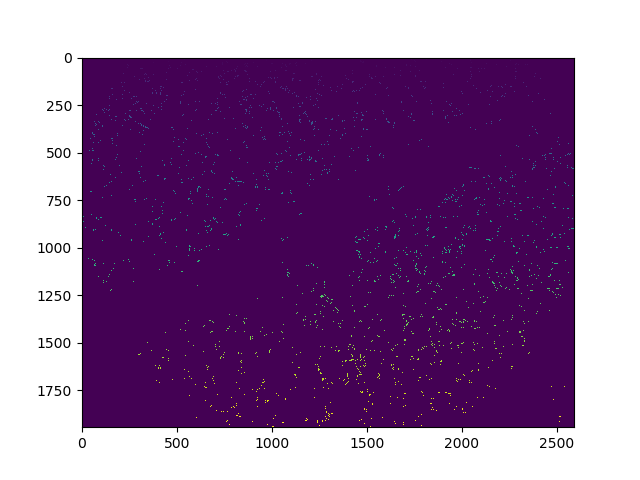

In [229]:
edges = np.zeros_like(photo_grey_nobg_rescaled)
edges[elevation_map > 30] = 255
labeled_edges , _ = ndi.label(edges)
plt.figure()
plt.imshow(labeled_edges)

### Identify labeled particles that also overlap with labeled in-focus edges.  Record those in-focus particle objects.

<IPython.core.display.Javascript object>


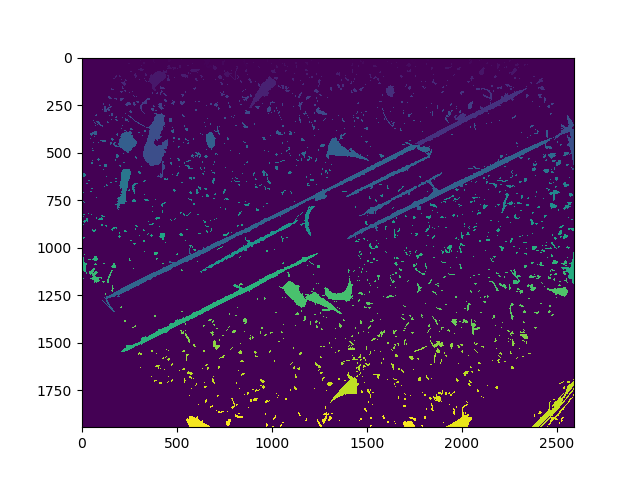

In [233]:
infocus_object_img = np.zeros_like(labeled_particles)
edge_properties = measure.regionprops(labeled_edges)
particle_properties = measure.regionprops(labeled_particles)
infocus_index=[]
for edge in edge_properties:
    e_coords = edge.coords
    for x in e_coords:
        infocus = labeled_particles[x[0],x[1]]
        if infocus not in infocus_index:
            infocus_index.append(infocus)
            
for y in infocus_index:
    infocus_object_img[labeled_particles==y] = y
infocus_object_img[infocus_object_img>0]=1
infocus_object_img, _ =ndi.label(infocus_object_img)
plt.figure()
plt.imshow(infocus_object_img)#,cmap=plt.cm.gray)

### Measure each of the detected particles

In [253]:
count = 0
particle_area = []
particle_ESD = []
particle_perimeter = []
particle_major_axis= []
particle_minor_axis= []
particle_numberID = []
file_name = []
particle_coordinates = []
bounding_box = []

scale_area = scale**2   #square pixels per square micron
properties = measure.regionprops(infocus_object_img)
for x in properties:
    count = count +1
    px_area=x.area
    um_area = px_area / scale_area
    min_axis = x.minor_axis_length / scale
    maj_axis = x.major_axis_length / scale
    perim = x.perimeter / scale
    ESD = 2*(math.sqrt(um_area/math.pi))
    particle_perimeter.append(perim)
    particle_major_axis.append(maj_axis)
    particle_minor_axis.append(min_axis)
    particle_area.append(um_area)
    particle_ESD.append(ESD)
    particle_numberID.append(count)
    file_name.append(file)
    name_words = file.split('_')
    particle_coordinates.append(np.ndarray.tolist(x.coords))
    bounding_box.append(str([x.bbox[0],x.bbox[2],x.bbox[1],x.bbox[3]]))


In [254]:
data = pd.DataFrame(np.stack((particle_numberID, particle_area, particle_ESD, particle_minor_axis, particle_major_axis, particle_perimeter, file_name, particle_coordinates, bounding_box),-1),columns=['Number','Area','ESD','minor_length','major_length','perimeter','file_name','particle_coordinates','bounding_box'])


In [255]:
data

,Number,Area,ESD,minor_length,major_length,perimeter,file_name,particle_coordinates,bounding_box
0,1,149830,436.771,445.563,581.296,2929.24,Sep__5_08-26-12_2018.jpg,"[[0, 196], [0, 197], [0, 198], [0, 199], [0, 2...","[0, 68, 192, 256]"
1,2,16170.9,143.49,66.9992,338.195,731.341,Sep__5_08-26-12_2018.jpg,"[[0, 349], [0, 350], [0, 351], [0, 352], [0, 3...","[0, 35, 349, 368]"
2,3,870.742,33.2966,24.8096,42.976,90.0175,Sep__5_08-26-12_2018.jpg,"[[0, 619], [0, 620], [0, 621], [0, 622], [0, 6...","[0, 3, 619, 624]"
3,4,4353.71,74.4534,42.4442,137.751,297.259,Sep__5_08-26-12_2018.jpg,"[[0, 874], [0, 875], [0, 876], [0, 877], [1, 8...","[0, 16, 874, 880]"
4,5,1181.72,38.7894,24.6255,62.2118,128.377,Sep__5_08-26-12_2018.jpg,"[[0, 1016], [0, 1017], [0, 1018], [0, 1019], [...","[0, 5, 1016, 1023]"
5,6,2861.01,60.3552,51.1159,78.1792,192.821,Sep__5_08-26-12_2018.jpg,"[[0, 1085], [0, 1086], [0, 1087], [0, 1088], [...","[0, 6, 1085, 1095]"
6,7,27366.2,186.665,104.179,417.378,930.463,Sep__5_08-26-12_2018.jpg,"[[0, 1113], [0, 1114], [0, 1115], [0, 1116], [...","[0, 42, 1090, 1121]"
7,8,1990.27,50.3397,27.0768,96.3095,189.555,Sep__5_08-26-12_2018.jpg,"[[0, 1249], [0, 1250], [0, 1251], [0, 1252], [...","[0, 11, 1249, 1253]"
8,9,14367.2,135.251,100.936,264.552,726.721,Sep__5_08-26-12_2018.jpg,"[[0, 1399], [0, 1400], [0, 1401], [0, 1402], [...","[0, 16, 1399, 1430]"
9,10,310.979,19.8985,14.1077,24.4352,41.0655,Sep__5_08-26-12_2018.jpg,"[[0, 1490], [0, 1491], [1, 1490], [1, 1491], [...","[0, 3, 1490, 1492]"
